In [17]:
import cv2 as cv
import numpy as np
import operator
from imutils import contours
import imutils

from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array

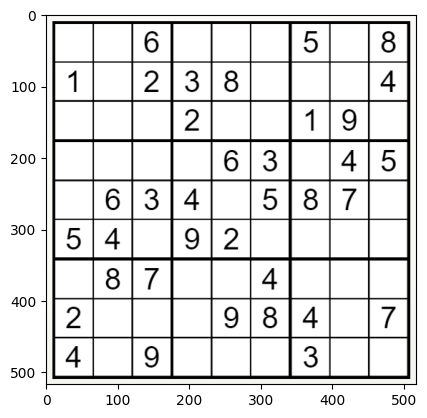

In [18]:

image = cv.imread('/content/drive/MyDrive/Colab Notebooks/Sudoku/sample.png')
p_image = image.copy()
plt.imshow(p_image)

In [19]:
#Process the image to find contour
gray=cv.cvtColor(image, cv.COLOR_BGR2GRAY)
gray=cv.GaussianBlur(gray, (5, 5), 0)
thresh=cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 9, 2)

#Get all the contours in the image
contours_, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contour = None
maxArea = 0

#Find the largest contour(Sudoku Grid)
for c in contours_:
    area = cv.contourArea(c)

    if area > 25000:
        peri = cv.arcLength(c, True)
        polygon = cv.approxPolyDP(c, 0.01*peri, True)

        if area>maxArea and len(polygon)==4:
            contour = polygon
            maxArea = area


print(contour , maxArea)

[[[  9  10]]

 [[  9 509]]

 [[508 509]]

 [[508  10]]] 249001.0


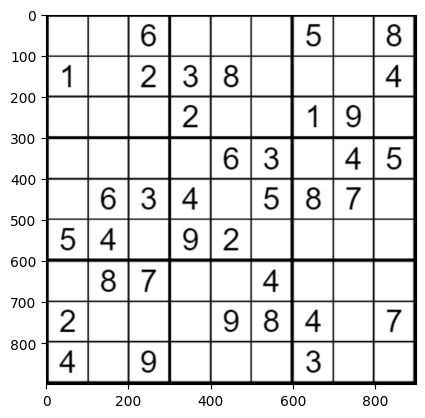

In [20]:
#Draw the contour and extract Sudoku Grid
if contour is not None:
    cv.drawContours(image, [contour], 0, (0, 255, 0), 2)
    points = np.vstack(contour).squeeze()
    points = sorted(points, key=operator.itemgetter(1))

    if points[0][0]<points[1][0]:
        if points[3][0]<points[2][0]:
            pts1 = np.float32([points[0], points[1], points[3], points[2]])
        else:
            pts1 = np.float32([points[0], points[1], points[2], points[3]])
    else:
        if points[3][0]<points[2][0]:
            pts1 = np.float32([points[1], points[0], points[3], points[2]])
        else:
            pts1 = np.float32([points[1], points[0], points[2], points[3]])

    pts2 = np.float32([[0, 0], [900, 0], [0, 900], [900, 900]])
    matrix = cv.getPerspectiveTransform(pts1, pts2)
    perspective_image =cv.warpPerspective(p_image, matrix, (900, 900))
    result = perspective_image.copy()

    plt.imshow(result)

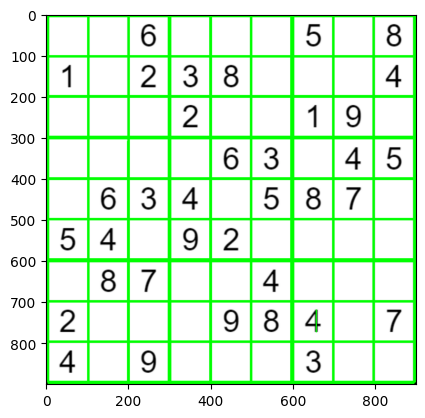

In [21]:
#Process the extracted Sudoku Grid
pers_image = cv.cvtColor(perspective_image, cv.COLOR_BGR2GRAY)
pers_image = cv.GaussianBlur(pers_image, (5, 5), 0)
pers_image = cv.adaptiveThreshold(pers_image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 9, 2)
vertical_kernel = cv.getStructuringElement(cv.MORPH_RECT,(5,5))
pers_image = cv.morphologyEx(pers_image, cv.MORPH_CLOSE, vertical_kernel)
lines = cv.HoughLinesP(pers_image, 1, np.pi/180, 120, minLineLength=40, maxLineGap=10)
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv.line(perspective_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(perspective_image)

(900, 900)


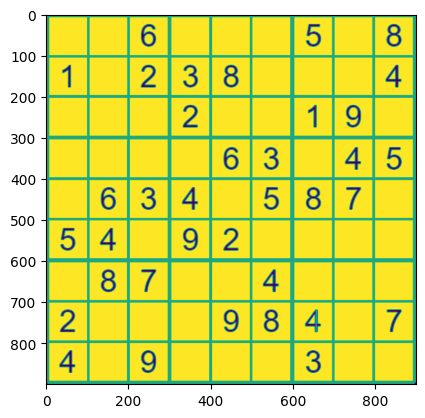

In [22]:
#Invert the grid for digit recognition
pers_image = cv.cvtColor(perspective_image, cv.COLOR_BGR2RGB)

pers_gray = cv.cvtColor(pers_image , cv.COLOR_RGB2GRAY)
plt.imshow(pers_gray)
print(pers_gray.shape)
invert = 255 - pers_image
invert_image = invert.copy()

invert_image = invert_image /255
i = 0



In [23]:
# loading trained model

new_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/adam-99.h5')

In [24]:
#Arranging predicted digit nested list
def display_predList(predList):
    predicted_digits = []
    for i in range(len(predList)):
        for j in range(len(predList)):
            predicted_digits.append(predList[j][i])

    return predicted_digits

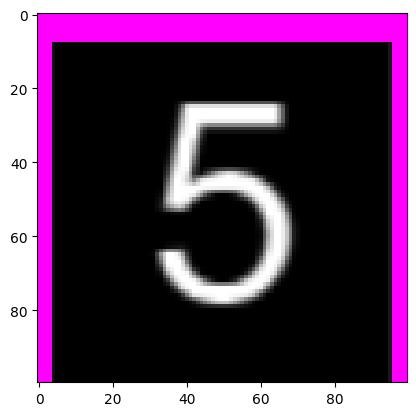

In [25]:
cell_block = invert_image.copy()
sels = []
roes = np.vsplit(cell_block,9)
for z in roes:
    cals = np.hsplit(z,9)
    for sel in cals:
        #sel = sel[10:80 , 10:80]
        #sel = (sel)/255.0
        plt.imshow( sel)
        #cv.waitKey(50)
        sels.append(sel)
plt.imshow(sels[6])

In [30]:
image = sels[6]
roi=cv.resize(image,(28,28))
roi=roi.astype("float32")/255.0
roi=img_to_array(roi)
roi=np.expand_dims(roi,axis=0)
print(roi.shape())
# pred=new_model.predict(roi)
plt.imshow(image)


TypeError: ignored

In [ ]:
digits = []
for sel in sels :
  image = cv.resize(sel, (28, 28))
  pred_sel = new_model.predict(image.reshape(1,28,28,1), batch_size=1)
  digits.append(pred_sel.argmax())

print(digits)

1/1 [==============================] - 0s 26ms/step
[0, 0, 6, 0, 0, 1, 6, 1, 0, 0, 0, 2, 8, 6, 1, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 6, 8, 0, 0, 6, 0, 6, 8, 0, 0, 6, 6, 0, 1, 6, 0, 0, 0, 8, 1, 0, 1, 1, 0, 6, 0, 0, 0, 0, 0, 1, 1, 8, 0, 0, 0, 0, 6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 8, 0, 1]
